## Setup

Load our Python modules:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

Load the data set:

In [3]:
sba = pd.read_csv('SBA/SBAcase.11.13.17.csv')
sba.head()

,Selected,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,...,ChgOffPrinGr,GrAppv,SBA_Appv,New,RealEstate,Portion,Recession,daysterm,xx,Default
0,0,1004285007,SIMPLEX OFFICE SOLUTIONS,ANAHEIM,CA,92801,CALIFORNIA BANK & TRUST,CA,532420,15074,...,0,30000,15000,0,0,0.5,0,1080,16175.0,0
1,1,1004535010,DREAM HOME REALTY,TORRANCE,CA,90505,CALIFORNIA BANK & TRUST,CA,531210,15130,...,0,30000,15000,0,0,0.5,1,1680,17658.0,0
2,0,1005005006,"Winset, Inc. dba Bankers Hill",SAN DIEGO,CA,92103,CALIFORNIA BANK & TRUST,CA,531210,15188,...,0,30000,15000,0,0,0.5,0,1080,16298.0,0
3,1,1005535001,Shiva Management,SAN DIEGO,CA,92108,CALIFORNIA BANK & TRUST,CA,531312,15719,...,0,50000,25000,0,0,0.5,0,1080,16816.0,0
4,1,1005996006,"GOLD CROWN HOME LOANS, INC",LOS ANGELES,CA,91345,SBA - EDF ENFORCEMENT ACTION,CO,531390,16840,...,0,343000,343000,0,1,1.0,0,7200,24103.0,0


And let's see our columns, just to take the lay of the land:

In [4]:
sba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102 entries, 0 to 2101
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Selected           2102 non-null   int64  
 1   LoanNr_ChkDgt      2102 non-null   int64  
 2   Name               2102 non-null   object 
 3   City               2102 non-null   object 
 4   State              2102 non-null   object 
 5   Zip                2102 non-null   int64  
 6   Bank               2099 non-null   object 
 7   BankState          2099 non-null   object 
 8   NAICS              2102 non-null   int64  
 9   ApprovalDate       2102 non-null   int64  
 10  ApprovalFY         2102 non-null   int64  
 11  Term               2102 non-null   int64  
 12  NoEmp              2102 non-null   int64  
 13  NewExist           2101 non-null   float64
 14  CreateJob          2102 non-null   int64  
 15  RetainedJob        2102 non-null   int64  
 16  FranchiseCode      2102 

## Probability of Default

Default status is encoded in the `Default` variable.

Since it is 0/1 (False/True behaves the same way), we can take the mean to compute $P(\mathrm{default})$:

In [5]:
sba['Default'].mean()

0.3263558515699334

Now we want to plot. A countplot is a good start, as it lets us get started:

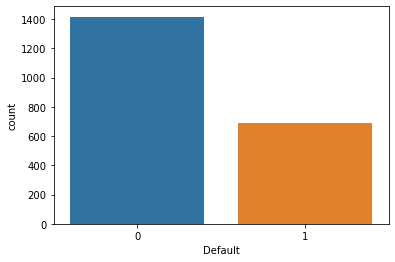

In [6]:
sns.countplot(sba['Default'])

But that isn't the *probability*.  We need to get more creative for that, by actually computing the probabilities.

So let's do that.  We can make a Pandas series that contains the probability of default or not, and turn it in to a data frame:

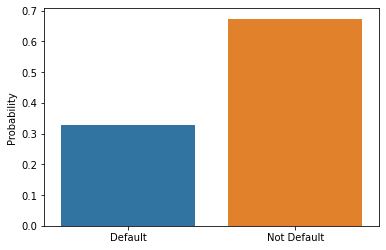

In [7]:
prob_dft = pd.Series({
    'Default': sba['Default'].mean(),
    'Not Default': 1 - sba['Default'].mean()
}, name='Probability')
sns.barplot(prob_dft.index, prob_dft)

## Conditional Probabilities

Now we want to think about the *conditional* probability of default. Let's look at it for new and existing businesses.

The 0-1 coding means we can take the mean, *grouped by the categorical*, to estimate the conditional probability P(default|new) (and P(default|existing)):

In [8]:
sba.groupby('NewExist')['Default'].mean()

NewExist
0.0    0.000000
1.0    0.323198
2.0    0.345679
Name: Default, dtype: float64

That isn't very readable, though. The data doc points to a cleaned up variable, `New`:

In [11]:
ne_prob_dft = sba.groupby('New')['Default'].mean()
ne_prob_dft

New
0    0.322835
1    0.345679
Name: Default, dtype: float64

That's easier to read, if we understand `New` as a logical coded as 1 for a new business. New businesses look more likely to default.

Computing a probability limited to data satisfying a condition is the same as computing the conditional probability.

What's a good way to plot this? We can just plot the probabilities side by side:

Text(0, 0.5, 'Probability of Default')

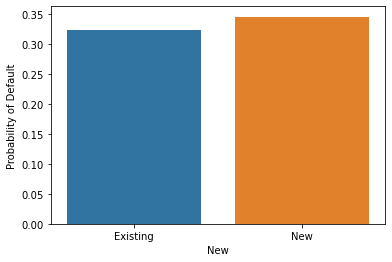

In [17]:
sns.barplot(ne_prob_dft.index, ne_prob_dft)
plt.xticks([0, 1], ['Existing', 'New'])
plt.ylabel('Probability of Default')

We could also do a bar chart where *x* is default and not-default, and colors are new/existing, and *y* is probability.

The statistical test for this is called a *proportion* test.  Scipy doesn't have one built in, but statsmodels does (I mentioned in class that scipy does, but I was incorrect).  It takes *arrays* of values:

- an array of success counts
- an array of total counts

It tests the **null hypothesis** that *all proportions are equal*.

We can set up our counts with `agg`:

In [18]:
ne_dft_stats = sba.groupby('New')['Default'].agg(['count', 'sum', 'mean'])
ne_dft_stats

,count,sum,mean
New,,,
0,1778,574,0.322835
1,324,112,0.345679


The columns are arrays, which will be fine for the proportion test.  Here we go:

In [19]:
sm.stats.proportions_ztest(ne_dft_stats['sum'], ne_dft_stats['count'])

(-0.806566494707552, 0.41991628376272316)

It returned two values:

1. The *z*-statistic, which is the underlying statistic it uses for the proportion test
2. The *p*-value

The *p*-value is large, so we **cannot reject the null hypothesis**.  That means, as near as we can tell from this data, default and new/existing business status are independent.

We can also bootstrap a p-value.  Like with the two-sample mean, we need to sample from the null distribution where *there is no difference*, and see how often we see a difference as large as we observed.

Let's get the observed difference:

In [20]:
ne_obs_diff = ne_dft_stats.loc[0, 'mean'] - ne_dft_stats.loc[1, 'mean']
ne_obs_diff

-0.022844366676387673

Now, we need to bootstrap. We're going to take samples from the `Default` column, and for each bootstrap, we're going to sample with replacement from the *entire* column (null hypothesis: no difference).  This time I'm going to do it with a loop rather than a comprehension; the `np.empty` function allocates a new array that we're going to fill with our observed differences:

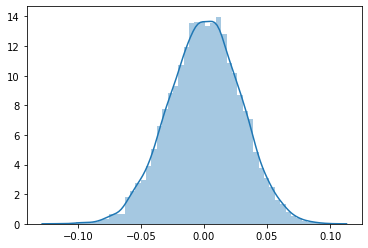

In [21]:
ne_boot_diffs = np.empty(10000)
for i in range(10000):
    samp0 = np.random.choice(sba['Default'], size=ne_dft_stats.loc[0, 'count'], replace=True)
    samp1 = np.random.choice(sba['Default'], size=ne_dft_stats.loc[1, 'count'], replace=True)
    ne_boot_diffs[i] = np.mean(samp0) - np.mean(samp1)
sns.distplot(ne_boot_diffs)

Now let's count occurrances, to compute our p-value:

In [22]:
np.mean(np.abs(ne_boot_diffs) >= np.abs(ne_obs_diff))

0.427

This is very close to the *p*-value computed by the proportion test, and is similarly too high to reject the null hypothesis.  Default and new business status look independent, at least in this data.